# Actor Critic

## Value based

\begin{equation} V_\theta(s) \approx V^\pi(s) \end{equation}
\begin{equation} Q_\theta(s, a) \approx Q^\pi(s, a) \end{equation}

We attemp to learn a value or action-value function given a specific policy. We use MC, TD... methods to estimate the target values. We imporve the policy by selecting the action in an $\epsilon$ - greedy fashion.

## Policy based

\begin{equation} \pi_\theta (s, a) = P[a | s, \theta] \end{equation}

We model a policy directly. 

Here we can again use a value function for optimization which can be written (in one step case) as:


\begin{equation} J(\theta) = \mathop{\mathbb{E}}_{\pi_\theta}[r] \end{equation}

Which can be expanded as:

\begin{equation} J(\theta) = \sum_s d(s) \sum_a \pi_\theta R_{s,a} \end{equation}

where d(s) is a stationary distribution of the MDP.

The gradient of the objective function can be writtern as:

\begin{equation} \nabla J(\theta) = \mathop{\mathbb{E}}_{\pi_\theta}[\nabla_\theta log\pi_\theta(s, a) \cdot r] \end{equation}

Thus, we can again use MC, TD... methods to estimate this gradient!

## Policy Gradient Theorem

Theorem: In case of multi-step MDPs, for anny differentiable policy $\pi_\theta(s, a)$, the policy gradient is:

\begin{equation}
\nabla_\theta J(\theta)
=
\mathop{\mathbb{E}}_{\pi_\theta}[\nabla_\theta log\pi_\theta(s, a) \cdot Q^{\pi_\theta}(s, a)]
\end{equation}

Simple MC algorithm:

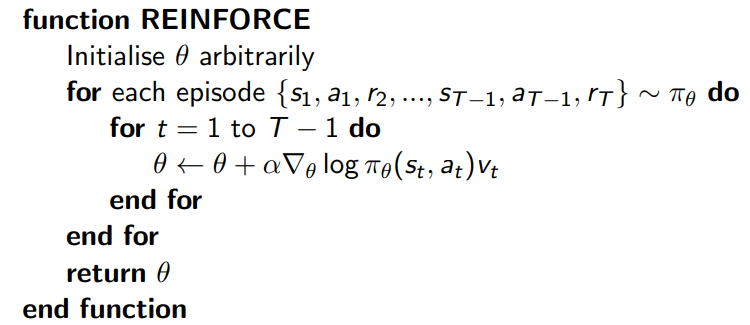


### The main problem is that the estimate of Q is very high variance!

#### Tip: Usually you should choose $\pi$ to be a Gaussian and model your $\mu$, while $\sigma$ can be modelled or parametrised. 

## Continous CartPole with modelled $\mu$ and decaying $\sigma$

In this case the log of the policy reduces to $ -\frac{(a - \mu(s))^2}{2 \sigma^2} $. So finally the loss function can be written as the mean-squared error of the choosen action with respect to the mean divided by the variance.
The environment code is taken from:  https://gist.github.com/iandanforth/e3ffb67cf3623153e968f2afdfb01dc8

In [3]:
from continuous_cart_pole_env import ContinuousCartPoleEnv

In [4]:
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gym 

In [5]:
env_name = 'ContinuousCartPoleEnv'
#env = gym.make(env_name)
env = ContinuousCartPoleEnv()

print(env.action_space.shape)
print(env.observation_space.shape)
print(env.action_space.low, env.action_space.high)

(1,)
(4,)
[-1.] [1.]


C:\Users\vuk11\miniconda3\envs\Torch\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
# Test

state = env.reset()
done = False
while not done:
    state, reward, done, info = env.step(env.action_space.sample())
    env.render()
    time.sleep(0.1)
env.close()

In [5]:
class Policy(nn.Module):
    def __init__(self, input_size, output_size):
        super(Policy, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32,1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return x

In [6]:
def get_action(state, agent, sigma):
    state = torch.tensor(state, dtype=torch.float32)
    mu = agent(state).item()
    action = np.random.normal(mu, sigma, 1)[0]
    action = max(action, -1)
    action = min(action, 1)
    
    # MUST BE CASTED AS np.array([action])
    return action

In [16]:
def play_optimally(agent, render = False):
    total_reward = 0
    done = False
    state = env.reset()
    
    while done is not True:
        action = agent(torch.tensor(state, dtype=torch.float32)).item()
        state, reward, done, info = env.step(np.array([action]))
        total_reward += reward
        
        if render is True:
            env.render()
            #time.sleep(0.1)
    
    print('The total reward is:', total_reward)
    env.close()

In [30]:
if True:
    env = ContinuousCartPoleEnv()
    play_optimally(agent, render=True)

The total reward is: 19.0


In [9]:
agent = Policy(4,1)
criterion = nn.MSELoss()
optimizer = optim.Adam(agent.parameters())

In [20]:
n_episode = 1000
sigma_max = 1
sigma_min = 0.05
rewards = []
running_loss = []
start = time.time()

for i_episode in range(n_episode):
    
    if i_episode % 100 == 99:
        print("\n")
        print("Completed:", i_episode + 1, "episodes")
        print("The time taken is:", time.time() - start, "s")
        print("The average reward so far:", np.mean(rewards))
        print("The average reward for the last 100 episodes:", np.mean(rewards[-100:-1]))
        
    
    sigma = max(sigma_max * ( 1 - 4 * i_episode / n_episode), sigma_min)
    
    
    state = env.reset()
    done = False
    history = []
    total_reward = 0
    
    # Play the episode
    while done is not True:
        with torch.no_grad():
            action = get_action(state, agent, sigma)
        
        next_state, reward, done, info = env.step(np.array([action]))
        
        history.append([state, action, reward])
        
        total_reward += reward
        state = next_state
        
        # Cap the maximum reward, otherwise it'll take forever after it learns the policy 
        if total_reward > 300:
            break
    rewards.append(total_reward)
    
    # Compute the action-value function
    # Essentially cumulative rewards looked from behind
    for i in range(len(history) - 2, - 1, -1):
        history[i][2] += history[i+1][2]
    
    for state, action, Q in history:
        mu = agent(torch.tensor(state, dtype=torch.float32))
        
        optimizer.zero_grad()
        loss = Q * criterion(torch.tensor(action, dtype=torch.float32), mu)
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.item())
        

C:\Users\vuk11\miniconda3\envs\Torch\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)




Completed: 100 episodes
The time taken is: 5.483607292175293 s
The average reward so far: 44.44444444444444
The average reward for the last 100 episodes: 44.43877551020408


Completed: 200 episodes
The time taken is: 25.121315479278564 s
The average reward so far: 101.20100502512562
The average reward for the last 100 episodes: 155.93939393939394


Completed: 300 episodes
The time taken is: 50.59170889854431 s
The average reward so far: 134.50167224080266
The average reward for the last 100 episodes: 201.91919191919192


Completed: 400 episodes
The time taken is: 72.74404978752136 s
The average reward so far: 144.17543859649123
The average reward for the last 100 episodes: 171.8080808080808


Completed: 500 episodes
The time taken is: 101.97030305862427 s
The average reward so far: 161.79559118236472
The average reward for the last 100 episodes: 232.4848484848485


Completed: 600 episodes
The time taken is: 116.34182476997375 s
The average reward so far: 153.34557595993323
The averag

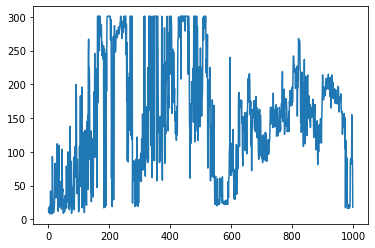

In [21]:
plt.plot(rewards)

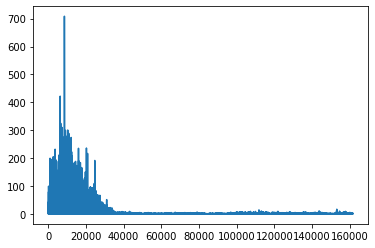

In [51]:
plt.plot(running_loss)

In [160]:
i_episode

189

In [13]:
from continuous_cart_pole_env import ContinuousCartPoleEnv
from policy_gradient import PolicyGradient

(1,)
(4,)
[-1.] [1.]
DONE


C:\Users\vuk11\miniconda3\envs\Torch\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
C:\Users\vuk11\miniconda3\envs\Torch\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [14]:
env_name = 'ContinuousCartPoleEnv'
#env = gym.make(env_name)
env = ContinuousCartPoleEnv()

print(env.action_space.shape)
print(env.observation_space.shape)
print(env.action_space.low, env.action_space.high)

(1,)
(4,)
[-1.] [1.]


In [18]:
agent = PolicyGradient(4, 1)
rewards = []

In [19]:
n_episode = 2000
sigma_max = 1
sigma_min = 0.05
start = time.time()

for i_episode in range(n_episode):
    
    if i_episode % 100 == 99:
        print("\n")
        print("Completed:", i_episode + 1, "episodes")
        print("The time taken is:", time.time() - start, "s")
        print("The average reward so far:", np.mean(rewards))
        print("The average reward for the last 100 episodes:", np.mean(rewards[-100:-1]))
        
    
    sigma = max(sigma_max * ( 1 -  2 * i_episode / n_episode), sigma_min)
    
    
    state = env.reset()
    done = False
    history = []
    total_reward = 0
    
    # Play the episode
    while done is not True:
        
        action = agent.get_action(state, sigma)
        
        next_state, reward, done, info = env.step(np.array([action]))
        
        history.append([state, action, reward])
        
        total_reward += reward
        state = next_state
        
        # Cap the maximum reward, otherwise it'll take forever after it learns the policy 
        if total_reward > 300:
            break
    rewards.append(total_reward)
    
    agent.update(history)



Completed: 100 episodes
The time taken is: 2.3736612796783447 s
The average reward so far: 20.535353535353536
The average reward for the last 100 episodes: 20.510204081632654


Completed: 200 episodes
The time taken is: 6.614129304885864 s
The average reward so far: 27.29145728643216
The average reward for the last 100 episodes: 34.22222222222222


Completed: 300 episodes
The time taken is: 11.302905082702637 s
The average reward so far: 30.37458193979933
The average reward for the last 100 episodes: 36.75757575757576


Completed: 400 episodes
The time taken is: 15.147094488143921 s
The average reward so far: 30.318295739348372
The average reward for the last 100 episodes: 30.242424242424242


Completed: 500 episodes
The time taken is: 20.507302045822144 s
The average reward so far: 32.46092184368737
The average reward for the last 100 episodes: 41.07070707070707


Completed: 600 episodes
The time taken is: 25.718586206436157 s
The average reward so far: 34.00500834724541
The average

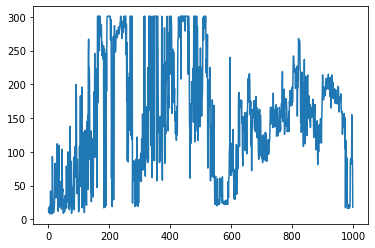

In [31]:
plt.plot(rewards)

# Actor Critic

In [6]:
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gym 
from continuous_cart_pole_env import ContinuousCartPoleEnv
from actor_critic import ActorCritic

In [7]:
env_name = 'ContinuousCartPoleEnv'
#env = gym.make(env_name)
env = ContinuousCartPoleEnv()

print(env.action_space.shape)
print(env.observation_space.shape)
print(env.action_space.low, env.action_space.high)

(1,)
(4,)
[-1.] [1.]


C:\Users\vuk11\miniconda3\envs\Torch\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# Online Updates

In [8]:
agent = ActorCritic(4, 1)
rewards = []
actor_running_loss = []
critic_running_loss = []

In [9]:
n_episode = 1000
sigma_max = 1
sigma_min = 0.01
start = time.time()

for i_episode in range(n_episode):
    
    if i_episode % 100 == 99:
        print("\n")
        print("Completed:", i_episode + 1, "episodes")
        print("The time taken is:", time.time() - start, "s")
        print("The average reward so far:", np.mean(rewards))
        print("The average reward for the last 100 episodes:", np.mean(rewards[-100:-1]))
        
    
    sigma = max(sigma_max * ( 1 -  1 / 2 * i_episode / n_episode), sigma_min)
    
    
    state = env.reset()
    done = False
    history = []
    total_reward = 0
    
    # Play the episode
    while done is not True:
        
        action = agent.get_action(state, sigma)
        
        next_state, reward, done, info = env.step(np.array([action]))
        
        history.append([state, action, reward, next_state, done])
        actor_loss, critic_loss = agent.update([[state, action, reward, next_state, done]])

        actor_running_loss.append(actor_loss[0])
        critic_running_loss.append(critic_loss[0])
        
        total_reward += reward
        state = next_state
        
        # Cap the maximum reward, otherwise it'll take forever after it learns the policy 
        if total_reward > 300:
            break
    rewards.append(total_reward)

C:\Users\vuk11\miniconda3\envs\Torch\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)




Completed: 100 episodes
The time taken is: 5.010599374771118 s
The average reward so far: 20.595959595959595
The average reward for the last 100 episodes: 20.489795918367346


Completed: 200 episodes
The time taken is: 11.766530275344849 s
The average reward so far: 24.889447236180903
The average reward for the last 100 episodes: 29.272727272727273


Completed: 300 episodes
The time taken is: 20.62783169746399 s
The average reward so far: 28.93979933110368
The average reward for the last 100 episodes: 36.86868686868687


Completed: 400 episodes
The time taken is: 37.58392834663391 s
The average reward so far: 37.49122807017544
The average reward for the last 100 episodes: 63.292929292929294


Completed: 500 episodes
The time taken is: 59.09624910354614 s
The average reward so far: 47.1563126252505
The average reward for the last 100 episodes: 86.11111111111111


Completed: 600 episodes
The time taken is: 83.59224438667297 s
The average reward so far: 55.636060100166944
The average re

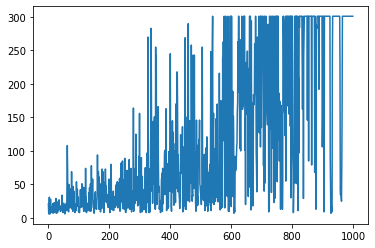

In [10]:
plt.plot(rewards)

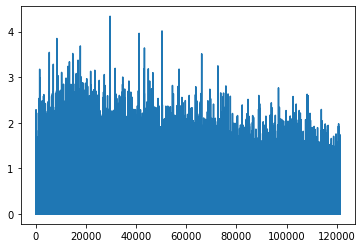

In [11]:
plt.plot(actor_running_loss)

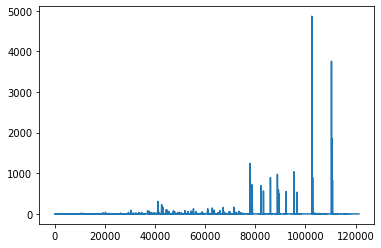

In [12]:
plt.plot(critic_running_loss)

In [13]:
def play_optimally(agent, render = False):
    total_reward = 0
    done = False
    state = env.reset()
    cnt = 0
    while done is not True:
        action = agent.get_action(state, sigma=0.0001)
        state, reward, done, info = env.step(np.array([action]))
        total_reward += reward
        
        if render is True:
            env.render()
            #time.sleep(0.1)
        cnt+= 1
        if cnt > 300:
            break
        
    
    print('The total reward is:', total_reward)
    env.close()

In [14]:
play_optimally(agent, True)

The total reward is: 301.0
